In [106]:
'''
Model parameters
'''
import random
import numpy as np

M = 4 # Number of Spiking motifs
N = 20 # Number of input neurons
D = 71 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 15 # hz
pg_fr = 6 # hz
background_noise_fr = 5 # h

np.random.seed(41)

In [107]:
'''
Setup
'''

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
disp_figs = True
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 101 colors (11 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])

In [108]:
'''
Synthetic Data Generation
'''
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)
K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)

# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)
B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,0] = np.random.randint(0,999,(N,T+D))
A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b-1]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
debug = A_dense
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(20, 1071)

In [109]:
'''
Post-processing and clustering
'''

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Windowing the data
window_dim = (int(np.ceil(D/2)), N) # choosing a window to surround the spikes, this is a prediction but for now we will use the a priori depth D
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0]) # spikes closer to border will not be counted for simplicity
A_trunc = (A_sparse[0][valid_spikes],A_sparse[1][valid_spikes].copy(),A_sparse[2][valid_spikes].copy()) # creating a new "A_sparse" with only valid spikes
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2)) # creating a matrix of all of the windows surrounding every spike in the matrix
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
    
HDPs = []
sim_mats = []
# Set the cutoff value for clustering
cutoff = 1

# Get the cluster assignments for each spike based on the hierarchical clustering
clusters = []
for n in range(N):
    test = windows[N_labels==n]
    if len(test) > 0:
        x = np.zeros((len(test),len(test)))
        for i in range(test.shape[0]):
            for j in range(test.shape[0]):
                x[i,j] = np.sum(test[i]*test[j])/ min(np.sum(test[i]),np.sum(test[j]))
        sim_mats.append(x)
        dissimilarity = 1 - x
        HDPs.append(linkage(dissimilarity, method='complete'))
        clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))

clusters= np.array(clusters)

time_differences = []
cluster_sq = {}
for cluster in np.unique(clusters):
    time_differences.append(list(np.diff(A_trunc[1][clusters == cluster])))
    if str(list(np.diff(A_trunc[1][clusters == cluster]))) in cluster_sq.keys():
        cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] + [cluster]
    else: 
        cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = [cluster]
        
''' 
This is the second round of clustering. Only patterns that repeat across multiple neurons are considered a motif. 


with some help from chatgpt
'''

from collections import Counter

# Convert the list of lists to a set of tuples to remove duplicates
unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

# Convert the set of tuples back to a list of lists
unique_sublists = [list(sublist) for sublist in unique_sublists_set]

# Count the occurrences of each unique sublist in the original list
sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

# Print the unique sublists and their respective counts
for sublist in unique_sublists:
    count = sublist_counts[tuple(sublist)]
    print(f"{sublist}: {count} occurrences")

sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron

''' to visualize the clusters'''

recovered_labels = np.zeros_like(clusters)
for l, key in enumerate(sublist_keys_filt):
    for k in cluster_sq[str(key)]:
        recovered_labels[clusters == k] = l+1

''' to get the timings'''

# Sort y according to x
sorted_indices = np.argsort(A_trunc[1])
sorted_x = A_trunc[1][sorted_indices]

all_times = []
all_labels = []
for key in sublist_keys_filt:
    pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
    for i,k in enumerate(cluster_sq[str(key)]):
        pattern_repetition_labels[i][clusters==k] = 1
        pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
    pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
    all_labels.append(pattern_repetition_labels)
    
    sorted_y = pattern_repetition_labels[sorted_indices]
    pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
    all_times.append(pattern_times)


C:\Users\miles\AppData\Local\Temp\ipykernel_12444\2770237764.py:35: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  HDPs.append(linkage(dissimilarity, method='complete'))
C:\Users\miles\AppData\Local\Temp\ipykernel_12444\2770237764.py:36: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))


[597]: 1 occurrences
[356]: 12 occurrences
[122, 92]: 1 occurrences
[91, 364]: 2 occurrences
[616, 122, 47]: 2 occurrences
[142]: 1 occurrences
[331]: 5 occurrences
[12, 312, 292]: 1 occurrences
[142, 124, 331]: 1 occurrences
[109, 0]: 1 occurrences
[604, 122]: 1 occurrences
[208, 247]: 2 occurrences
[12, 312, 292, 169]: 1 occurrences
[91, 364, 181]: 1 occurrences
[312, 292, 122, 47]: 1 occurrences
[91, 33, 331, 181]: 1 occurrences
[208]: 2 occurrences
[266]: 3 occurrences
[12, 312, 292, 122, 47]: 8 occurrences
[124, 512]: 1 occurrences
[142, 91, 33, 331]: 5 occurrences
[342, 109]: 10 occurrences
[0]: 3 occurrences
[12, 312, 292, 122]: 5 occurrences
[738]: 1 occurrences
[122, 47]: 1 occurrences
[12, 604, 122, 47]: 1 occurrences
[94]: 4 occurrences
[91]: 1 occurrences
[312, 292, 122]: 1 occurrences
[109]: 7 occurrences
[353]: 7 occurrences


In [110]:
'''
Mapping Cluster Labels for Visualization
'''

from scipy.optimize import linear_sum_assignment

labels_array_1 = recovered_labels
labels_array_2 = A_trunc[2]

# Get unique labels from both arrays
unique_labels_1 = np.unique(labels_array_1)
unique_labels_2 = np.unique(labels_array_2)

# Create a cost matrix where each entry represents the cost of matching two labels
cost_matrix = np.zeros((len(unique_labels_1), len(unique_labels_2)))

for i, label_1 in enumerate(unique_labels_1):
    for j, label_2 in enumerate(unique_labels_2):
        common_elements = np.logical_and(labels_array_1 == label_1, labels_array_2 == label_2)
        cost_matrix[i, j] = -np.sum(common_elements)

# Use the Hungarian algorithm to find the optimal mapping
row_indices, col_indices = linear_sum_assignment(cost_matrix)

# Create a dictionary to store the many-to-one mapping
mapping_dict = {}

# Populate the mapping dictionary with the optimal mapping
for i, j in zip(row_indices, col_indices):
    label_1 = unique_labels_1[i]
    label_2 = unique_labels_2[j]
    
    if label_1 in mapping_dict:
        mapping_dict[label_1].append(label_2)
    else:
        mapping_dict[label_1] = [label_2]

# Find unmatched labels from labels_array_1
unmatched_labels_1 = np.setdiff1d(unique_labels_1, list(mapping_dict.keys()))

# Handle unmatched labels by assigning them to the closest label in labels_array_2
for label_1 in unmatched_labels_1:
    closest_label_2 = unique_labels_2[np.argmin(cost_matrix[label_1, :])]
    mapping_dict[label_1] = [closest_label_2]

# Map the labels from labels_array_1 to labels_array_2 using the mapping dictionary
# Use the get method with a default value of -1 for labels without a mapping
mapped_labels = np.array([mapping_dict[label] for label in labels_array_1]).squeeze()



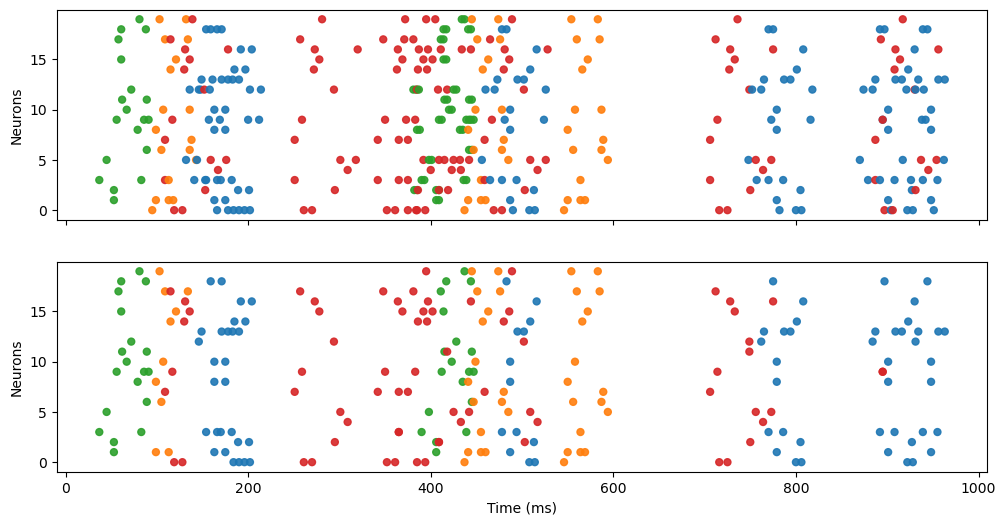

In [111]:
%matplotlib inline

sort_criteria_1 = mapped_labels
sort_criteria_2 = mapped_labels

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot data on the first subplot (ax1)
scatter1 = ax1.scatter(A_trunc[1][A_trunc[2]!=0], A_trunc[0][A_trunc[2]!=0], c=palette[A_trunc[2][A_trunc[2]!=0]], alpha=0.9, s=100, marker='.')
ax1.set_ylabel('Neurons')

# Plot data on the second subplot (ax2)
scatter2 = ax2.scatter(A_trunc[1][sort_criteria_1 != 0], A_trunc[0][sort_criteria_1 != 0], c=palette[sort_criteria_1[sort_criteria_1 != 0]], alpha=0.9, s=100, marker='.')
ax2.set_ylabel('Neurons')
ax2.set_xlabel('Time (ms)')

# Show the plots
plt.show()


In [32]:
'''
Performance
'''

TP = 0
TN = 0
total_TP = 0
total_TN = 0
for m in range(M):
    TP += np.sum(((A_trunc[2]==m) & (mapped_labels==m)) == True)
    TN += np.sum(((A_trunc[2]!=m) & (mapped_labels!=m)) == True)
    total_TP += np.sum(A_trunc[2]==m)
    total_TN += np.sum(A_trunc[2]!=m)
    
print(TP/total_TP, TN/total_TN, total_TP,total_TN)

(0.8394160583941606, 0.8584615384615385, 137, 325)